In [1]:
import numpy as np
from scipy.linalg import eig_banded

#Assuming s=-2, l>2, -l<=m<=l with waveform amplitudes in mind.
#Using l for spherical modes, j for spheroidal.

#The diagonals of the banded matrix system for the spheroidal to spherical mode mixing coefficients. 
def d(l, m, gamma):
    return (
        -2 
        + l * (1 + l) 
        - (8 * m * gamma) / (l + l**2) 
        - (1/3) * (1 + (2 * (-3 + l) * (4 + l) * (l + l**2 - 3 * m**2)) / 
        (l * (-3 + l + 4 * l**2 * (2 + l)))) * gamma**2
    )

def dk1(l, m, gamma):
    return -(
        (4 * np.sqrt(
            ((-1 + l) * (3 + l) * (1 + 2 * l) * (1 + l - m) * (1 + l + m)) /
            (3 + 2 * l)
        ) * gamma * (l * (2 + l) + m * gamma)) /
        (l * (1 + l) * (2 + l) * (1 + 2 * l))
    )

def dk2(l, m, gamma):
    sqrt_term = np.sqrt(
        ((-1 + l) * l * (3 + l) * (4 + l) * (1 + l - m) * (2 + l - m) * (1 + l + m) * (2 + l + m)) /
        ((1 + l)**2 * (2 + l)**2 * (1 + 2 * l) * (3 + 2 * l)**2 * (5 + 2 * l))
    )
    return -sqrt_term * gamma**2

def spheroidal_in_spherical(j, m, gamma, num):
    lmin = max(2, abs(m))
    
    a_band = np.zeros((3, num))
    for i in range(num):
        a_band[0, i] = d(lmin + i, m, gamma)
        a_band[1, i] = dk1(lmin + i, m, gamma)
        a_band[2, i] = dk2(lmin + i, m, gamma)
        
    eigenvals, eigenvects = eig_banded(a_band, lower=True)
    eigenvect = np.transpose(eigenvects)
    
    # enforce sign convention that j=l mode is positive - adapted from Zach's spheroidal package as this is neater than toolkit.
    sign = np.sign(eigenvect[int(j - lmin)][int(j - lmin)])
    
    return sign * eigenvect[int(j - lmin)]

def sphericalmodefromspheroidal(l, m, gamma, spheroidalmodes):
    
    if isinstance(spheroidalmodes,np.ndarray) and spheroidalmodes.ndim==1:
        n = len(spheroidalmodes)
    else:
        print("Invalid. spheroidalmodes must be a one dimensional numpy array of modes (beginning at spheroidal l=2) for a given m value. ")
        return None

    ljmin = max(2, abs(m))
    jmax = n + 1

    #postion of jmin in spheroidal modes list
    sumfrom = ljmin -2

    #Vary number of terms by accuracy requirements? This should do for now (compute minumum number of terms +9):
    num_min = l-(ljmin-1)
    num=num_min + 9

    
    sphericalmode = 0

    #Ensuring we compute enough coefficients to include the relevant l mode based of automatic number of terms included.
    for i in range(n):
        sphericalmode += (spheroidal_in_spherical(ljmin+i, m, gamma, num)[l-ljmin])*spheroidalmodes[sumfrom+i]

    return sphericalmode
    

Import PN data for plot 1:

In [2]:
#Array for given spheroidal l mode (2,3,4,5,6) ,m=2,n=0 containting entries of [e,a,Re[Amp],Im[Amp]] for p=100, prograde.
PNp1l2m2n0 = np.loadtxt('5PN_e10_mathematica/p1l2m2n0.csv', delimiter=',')
PNp1l3m2n0 = np.loadtxt('5PN_e10_mathematica/p1l3m2n0.csv', delimiter=',')
PNp1l4m2n0 = np.loadtxt('5PN_e10_mathematica/p1l4m2n0.csv', delimiter=',')
PNp1l5m2n0 = np.loadtxt('5PN_e10_mathematica/p1l5m2n0.csv', delimiter=',')
PNp1l6m2n0 = np.loadtxt('5PN_e10_mathematica/p1l6m2n0.csv', delimiter=',')

#Array for given spheroidal l mode (2,3,4,5,6) ,m=2,n=1 containting entries of [e,a,Re[Amp],Im[Amp]] for p=100
PNp1l2m2n1 = np.loadtxt('5PN_e10_mathematica/p1l2m2n1.csv', delimiter=',')
PNp1l3m2n1 = np.loadtxt('5PN_e10_mathematica/p1l3m2n1.csv', delimiter=',')
PNp1l4m2n1 = np.loadtxt('5PN_e10_mathematica/p1l4m2n1.csv', delimiter=',')
PNp1l5m2n1 = np.loadtxt('5PN_e10_mathematica/p1l5m2n1.csv', delimiter=',')
PNp1l6m2n1 = np.loadtxt('5PN_e10_mathematica/p1l6m2n1.csv', delimiter=',')

Now convert to list of entries of [e,a,Re[Amp],Im[Amp]] for p=100, prograde for $\textbf{spherical}$ (l=2, m=2,n=0) and (l=2, m=2,n=1) 

In [3]:
from few.utils.utility import get_fundamental_frequencies

#l=2,m=2,n=0 spherical mode:
PNp1l2m2n0spherical=np.zeros(np.shape(PNp1l2m2n0));

for i in range(0,np.shape(PNp1l2m2n0)[0]):
    inputmodesRe=np.array([PNp1l2m2n0[i][2],PNp1l3m2n0[i][2],PNp1l4m2n0[i][2],PNp1l5m2n0[i][2],PNp1l6m2n0[i][2]])
    inputmodesIm=np.array([PNp1l2m2n0[i][3],PNp1l3m2n0[i][3],PNp1l4m2n0[i][3],PNp1l5m2n0[i][3],PNp1l6m2n0[i][3]])

    a=PNp1l2m2n0[i][1]
    p=float(100)
    e=PNp1l2m2n0[i][0]
    x=1
    
    #spheroidicity gamma=a omega
    phifreq, thetafreq, radfreq=get_fundamental_frequencies(a, p, e, x)
    omega=2*phifreq #+0*radfreq
    gamma=a*omega
    
    outputmodeRe=sphericalmodefromspheroidal(2, 2, gamma, inputmodesRe)
    outputmodeIm=sphericalmodefromspheroidal(2, 2, gamma, inputmodesIm)

    PNp1l2m2n0spherical[i][0]=PNp1l2m2n0[i][0]
    PNp1l2m2n0spherical[i][1]=PNp1l2m2n0[i][1]

    PNp1l2m2n0spherical[i][2]=outputmodeRe
    PNp1l2m2n0spherical[i][3]=outputmodeIm   


#l=2,m=2,n=1 spherical mode:
PNp1l2m2n1spherical=np.zeros(np.shape(PNp1l2m2n1));

for i in range(0,np.shape(PNp1l2m2n1)[0]):
    inputmodesRe=np.array([PNp1l2m2n1[i][2],PNp1l3m2n1[i][2],PNp1l4m2n1[i][2],PNp1l5m2n1[i][2],PNp1l6m2n1[i][2]])
    inputmodesIm=np.array([PNp1l2m2n1[i][3],PNp1l3m2n1[i][3],PNp1l4m2n1[i][3],PNp1l5m2n1[i][3],PNp1l6m2n1[i][3]])

    a=PNp1l2m2n1[i][1]
    p=float(100)
    e=PNp1l2m2n1[i][0]
    x=1
    
    #spheroidicity gamma=a omega
    phifreq, thetafreq, radfreq=get_fundamental_frequencies(a, p, e, x)
    omega=2*phifreq +1*radfreq
    gamma=a*omega
    
    outputmodeRe=sphericalmodefromspheroidal(2, 2, gamma, inputmodesRe)
    outputmodeIm=sphericalmodefromspheroidal(2, 2, gamma, inputmodesIm)

    PNp1l2m2n1spherical[i][0]=e
    PNp1l2m2n1spherical[i][1]=a

    PNp1l2m2n1spherical[i][2]=outputmodeRe
    PNp1l2m2n1spherical[i][3]=outputmodeIm 

Generate equivalent data using few:

In [4]:
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
amp_module = AmpInterpKerrEccEq()

def compareamps(dataPN,n):
    
    length=dataPN.shape[0]

    reldiffs= np.zeros((length,8))
    for i in range(length):
        
        e=dataPN[i][0]
        a=dataPN[i][1]

        ampval = amp_module(a, float(100), e, 1, specific_modes=[(2, 2, n)])[(2,2,n)][0]
        
        reampPN=-dataPN[i][2] #Extra minus sign it seems from convention
        imampPN=-dataPN[i][3] #Extra minus sign it seems from convention
        
        reampfew=np.real(ampval)
        imampfew=np.imag(ampval)

        rediff=np.log10(abs(1-(reampfew/reampPN)))
        imdiff=np.log10(abs(1-(imampfew/imampPN)))

        reldiffs[i][0]=e
        reldiffs[i][1]=a
        reldiffs[i][2]=rediff
        reldiffs[i][3]=imdiff
        
        reldiffs[i][4]=reampfew #Store both PN amps and few amps for inspection if need be
        reldiffs[i][5]=imampfew
        reldiffs[i][6]=reampPN
        reldiffs[i][7]=imampPN

    return reldiffs

In [5]:
l2m2n0diffs=compareamps(PNp1l2m2n0spherical,0)
l2m2n1diffs=compareamps(PNp1l2m2n1spherical,1)

In [6]:
import matplotlib.pyplot as plt

def plot_diffs(array,n):

    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Computer Modern"]

    label_fontsize = 14
    tick_fontsize = 14
    title_fontsize = 16

    # Extract the e, a, z1=real part amp rel diff, and z2=im part amp rel diff values from the array
    e = array[:, 0]
    a = array[:, 1]
    z1 = array[:, 2]
    z2 = array[:, 3]
    

 
    # Create a figure with four subplots
    fig, axes = plt.subplots(2, 1, figsize=(6,10))

    # Plot the pdot rel diff using scatter plot
    scatter1 = axes[0].scatter(e,a, c=z1, cmap='plasma',rasterized=True)
    axes[0].set_title(rf'$\log_{{10}} \left(| 1 - Re[A_{{22{n}}}]^{{FEW}}/ Re[A_{{22{n}}}]^{{PN}} | \right)$', fontsize=title_fontsize)
    axes[0].set_xlabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    axes[0].set_ylabel(r'Kerr spin $(a)$', fontsize=label_fontsize)
    
    axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatter1, ax=axes[0])

    # Plot the edot rel diff using scatter plot
    scatter2 = axes[1].scatter(e, a, c=z2, cmap='plasma',rasterized=True)
    axes[1].set_title(rf'$\log_{{10}} \left(| 1 - Im[A_{{22{n}}}]^{{FEW}}/ Im[A_{{22{n}}}]^{{PN}} | \right)$', fontsize=title_fontsize)
    axes[1].set_xlabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    axes[1].set_ylabel(r'Kerr spin $(a)$', fontsize=label_fontsize)
    
    axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatter2, ax=axes[1])

    # Display the plots
    plt.tight_layout()

    # if x==-1:
    #     figurename=f'FluxComparisonBHPC_{a}_retro.pdf'
    # elif x==1:
    #     figurename=f'FluxComparisonBHPC_{a}_pro.pdf'
    # else:
    #     Print("Input should be x=1 for prograde or x=-1 for retrograde")

    # plt.savefig(figurename)
    plt.show()  

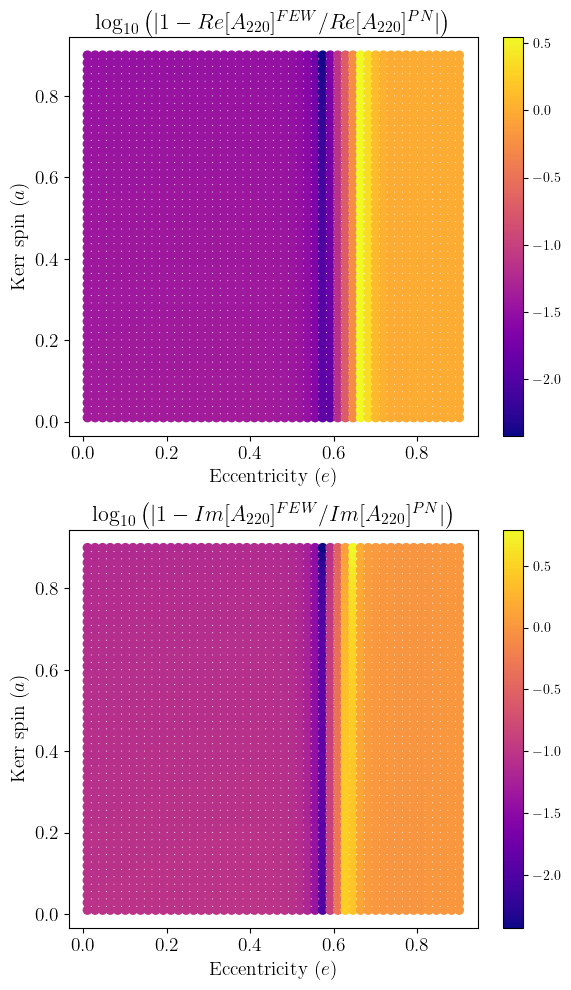

In [7]:
plot_diffs(l2m2n0diffs,0)

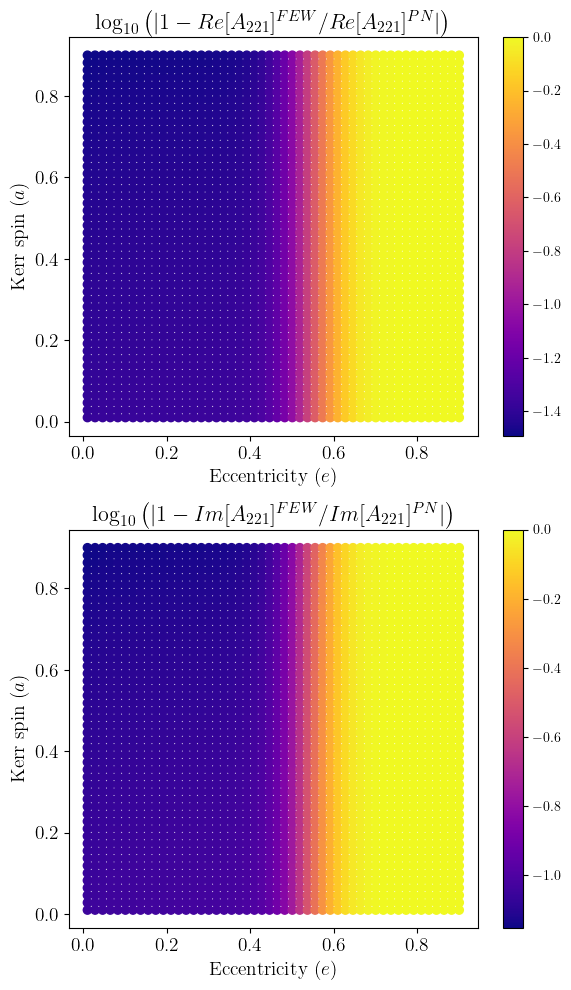

In [8]:
plot_diffs(l2m2n1diffs,1)

Fairly agnostic in a (expected at large p). Check plot 2 varying in p instead at fixed a.

In [9]:
#Array for given spheroidal l mode (2,3,4,5,6) ,m=2,n=0 containting entries of [p,e,Re[Amp],Im[Amp]] for a=0.998, prograde.
PNp2l2m2n0 = np.loadtxt('5PN_e10_mathematica/p2l2m2n0.csv', delimiter=',')
PNp2l3m2n0 = np.loadtxt('5PN_e10_mathematica/p2l3m2n0.csv', delimiter=',')
PNp2l4m2n0 = np.loadtxt('5PN_e10_mathematica/p2l4m2n0.csv', delimiter=',')
PNp2l5m2n0 = np.loadtxt('5PN_e10_mathematica/p2l5m2n0.csv', delimiter=',')
PNp2l6m2n0 = np.loadtxt('5PN_e10_mathematica/p2l6m2n0.csv', delimiter=',')

#Array for given spheroidal l mode (2,3,4,5,6) ,m=2,n=1 containting entries of [p,e,Re[Amp],Im[Amp]] for a=0.998. prograde.
PNp2l2m2n1 = np.loadtxt('5PN_e10_mathematica/p2l2m2n1.csv', delimiter=',')
PNp2l3m2n1 = np.loadtxt('5PN_e10_mathematica/p2l3m2n1.csv', delimiter=',')
PNp2l4m2n1 = np.loadtxt('5PN_e10_mathematica/p2l4m2n1.csv', delimiter=',')
PNp2l5m2n1 = np.loadtxt('5PN_e10_mathematica/p2l5m2n1.csv', delimiter=',')
PNp2l6m2n1 = np.loadtxt('5PN_e10_mathematica/p2l6m2n1.csv', delimiter=',')

Converting to spherical:

In [10]:
#l=2,m=2,n=0 spherical mode:
PNp2l2m2n0spherical=np.zeros(np.shape(PNp2l2m2n0));

for i in range(0,np.shape(PNp2l2m2n0)[0]):
    inputmodesRe=np.array([PNp2l2m2n0[i][2],PNp2l3m2n0[i][2],PNp2l4m2n0[i][2],PNp2l5m2n0[i][2],PNp2l6m2n0[i][2]])
    inputmodesIm=np.array([PNp2l2m2n0[i][3],PNp2l3m2n0[i][3],PNp2l4m2n0[i][3],PNp2l5m2n0[i][3],PNp2l6m2n0[i][3]])

    a=float(0.998)
    p=PNp2l2m2n0[i][0]
    e=PNp2l2m2n0[i][1]
    x=1
    
    #spheroidicity gamma=a omega
    phifreq, thetafreq, radfreq=get_fundamental_frequencies(a, p, e, x)
    omega=2*phifreq #+0*radfreq
    gamma=a*omega
    
    outputmodeRe=sphericalmodefromspheroidal(2, 2, gamma, inputmodesRe)
    outputmodeIm=sphericalmodefromspheroidal(2, 2, gamma, inputmodesIm)

    PNp2l2m2n0spherical[i][0]=p
    PNp2l2m2n0spherical[i][1]=e

    PNp2l2m2n0spherical[i][2]=outputmodeRe
    PNp2l2m2n0spherical[i][3]=outputmodeIm   


#l=2,m=2,n=1 spherical mode:
PNp2l2m2n1spherical=np.zeros(np.shape(PNp2l2m2n1));

for i in range(0,np.shape(PNp2l2m2n1)[0]):
    inputmodesRe=np.array([PNp2l2m2n1[i][2],PNp2l3m2n1[i][2],PNp2l4m2n1[i][2],PNp2l5m2n1[i][2],PNp2l6m2n1[i][2]])
    inputmodesIm=np.array([PNp2l2m2n1[i][3],PNp2l3m2n1[i][3],PNp2l4m2n1[i][3],PNp2l5m2n1[i][3],PNp2l6m2n1[i][3]])

    a=float(0.998)
    p=PNp2l2m2n1[i][0]
    e=PNp2l2m2n1[i][1]
    x=1
    
    #spheroidicity gamma=a omega
    phifreq, thetafreq, radfreq=get_fundamental_frequencies(a, p, e, x)
    omega=2*phifreq +1*radfreq
    gamma=a*omega
    
    outputmodeRe=sphericalmodefromspheroidal(2, 2, gamma, inputmodesRe)
    outputmodeIm=sphericalmodefromspheroidal(2, 2, gamma, inputmodesIm)

    PNp2l2m2n1spherical[i][0]=p
    PNp2l2m2n1spherical[i][1]=e

    PNp2l2m2n1spherical[i][2]=outputmodeRe
    PNp2l2m2n1spherical[i][3]=outputmodeIm 

In [11]:
def compareamps2(dataPN,n):
    
    length=dataPN.shape[0]

    reldiffs= np.zeros((length,8))
    for i in range(length):

        p=dataPN[i][0]
        e=dataPN[i][1]
        a=float(0.998)

        ampval = amp_module(a, p, e, 1, specific_modes=[(2, 2, n)])[(2,2,n)][0]
        
        reampPN=-dataPN[i][2] #Extra minus sign it seems from convention
        imampPN=-dataPN[i][3] #Extra minus sign it seems from convention
        
        reampfew=np.real(ampval)
        imampfew=np.imag(ampval)

        rediff=np.log10(abs(1-(reampfew/reampPN)))
        imdiff=np.log10(abs(1-(imampfew/imampPN)))

        reldiffs[i][0]=p
        reldiffs[i][1]=e
        reldiffs[i][2]=rediff
        reldiffs[i][3]=imdiff
        
        reldiffs[i][4]=reampfew #Store both PN amps and few amps for inspection if need be
        reldiffs[i][5]=imampfew
        reldiffs[i][6]=reampPN
        reldiffs[i][7]=imampPN

    return reldiffs

In [12]:
p2l2m2n0diffs=compareamps2(PNp2l2m2n0spherical,0)
p2l2m2n1diffs=compareamps2(PNp2l2m2n1spherical,1)

In [26]:
def plot_diffs2(array,n):

    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Computer Modern"]

    label_fontsize = 14
    tick_fontsize = 14
    title_fontsize = 16

    # Extract the e, a, z1=real part amp rel diff, and z2=im part amp rel diff values from the array
    p = array[:, 0]
    e = array[:, 1]
    z1 = array[:, 2]
    z2 = array[:, 3]
    

 
    # Create a figure with four subplots
    fig, axes = plt.subplots(2, 1, figsize=(6,10))

    # Plot the pdot rel diff using scatter plot
    scatter1 = axes[0].scatter(p, e, c=z1, cmap='plasma',rasterized=True,vmax=0)
    axes[0].set_title(rf'$\log_{{10}} \left(| 1 - Re[A_{{22{n}}}]^{{FEW}}/ Re[A_{{22{n}}}]^{{PN}} | \right)$', fontsize=title_fontsize)
    axes[0].set_xlabel(r'Semilatus rectum $(p)$', fontsize=label_fontsize)
    axes[0].set_ylabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    
    axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatter1, ax=axes[0])

    # Plot the edot rel diff using scatter plot
    scatter2 = axes[1].scatter(p, e, c=z2, cmap='plasma',rasterized=True,vmax=0)
    axes[1].set_title(rf'$\log_{{10}} \left(| 1 - Im[A_{{22{n}}}]^{{FEW}}/ Im[A_{{22{n}}}]^{{PN}} | \right)$', fontsize=title_fontsize)
    axes[1].set_xlabel(r'Semilatus rectum $(p)$', fontsize=label_fontsize)
    axes[1].set_ylabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    
    axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatter2, ax=axes[1])

    # Display the plots
    plt.tight_layout()


    figurename=f'A22{n}Comparison5PN.pdf'

    plt.savefig(figurename)
    plt.show()  

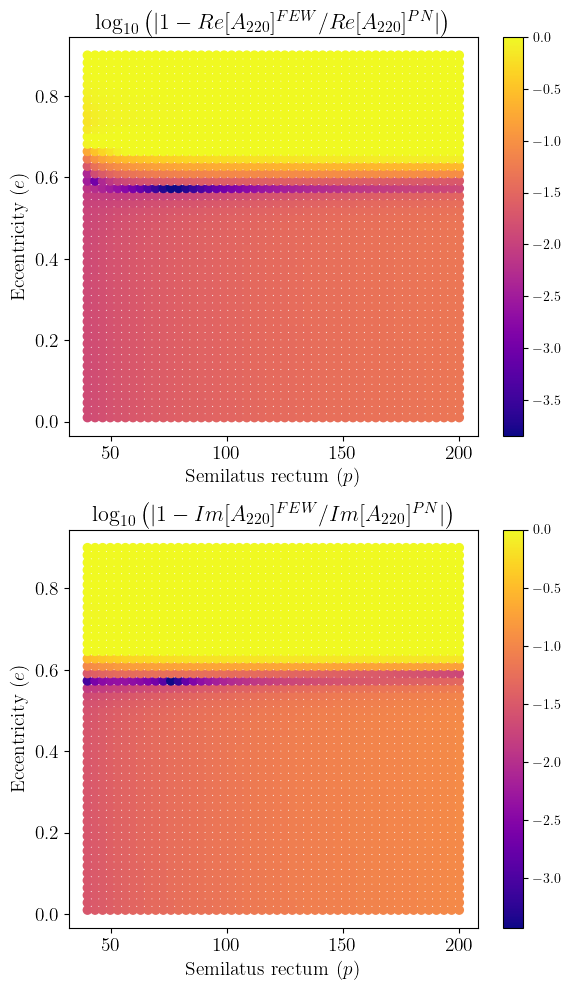

In [27]:
plot_diffs2(p2l2m2n0diffs,0)

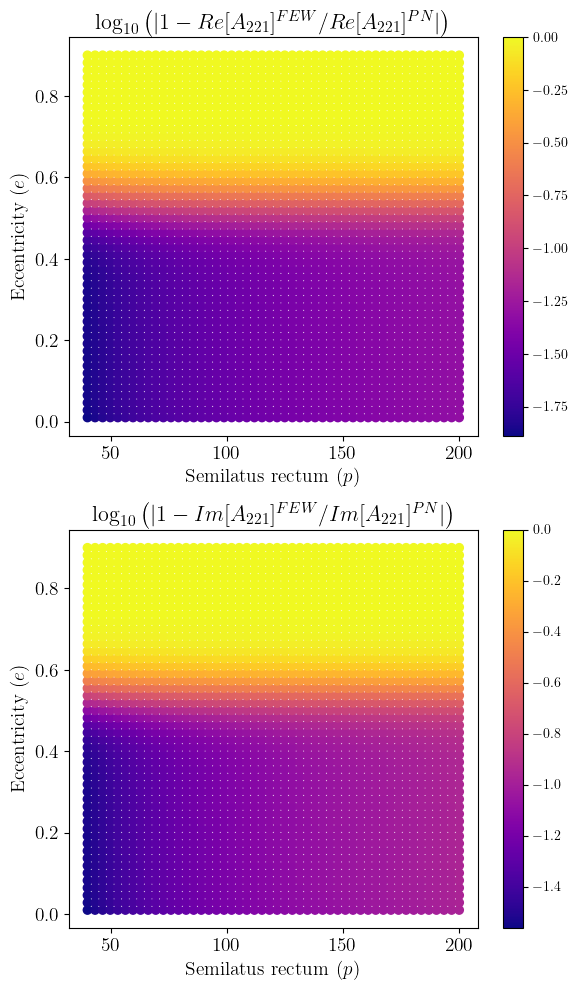

In [28]:
plot_diffs2(p2l2m2n1diffs,1)

Make one more plot in strong field to see if agreement imporves in the (presumably) more densely populated region. Plot 3 data:

In [16]:
#Array for given spheroidal l mode (2,3,4,5,6) ,m=2,n=0 containting entries of [p-plso,e,Re[Amp],Im[Amp]] for a=0.998, prograde.
PNp3l2m2n0 = np.loadtxt('5PN_e10_mathematica/p3l2m2n0.csv', delimiter=',')
PNp3l3m2n0 = np.loadtxt('5PN_e10_mathematica/p3l3m2n0.csv', delimiter=',')
PNp3l4m2n0 = np.loadtxt('5PN_e10_mathematica/p3l4m2n0.csv', delimiter=',')
PNp3l5m2n0 = np.loadtxt('5PN_e10_mathematica/p3l5m2n0.csv', delimiter=',')
PNp3l6m2n0 = np.loadtxt('5PN_e10_mathematica/p3l6m2n0.csv', delimiter=',')

#Array for given spheroidal l mode (2,3,4,5,6) ,m=2,n=1 containting entries of [p-plso,e,Re[Amp],Im[Amp]] for a=0.998. prograde.
PNp3l2m2n1 = np.loadtxt('5PN_e10_mathematica/p3l2m2n1.csv', delimiter=',')
PNp3l3m2n1 = np.loadtxt('5PN_e10_mathematica/p3l3m2n1.csv', delimiter=',')
PNp3l4m2n1 = np.loadtxt('5PN_e10_mathematica/p3l4m2n1.csv', delimiter=',')
PNp3l5m2n1 = np.loadtxt('5PN_e10_mathematica/p3l5m2n1.csv', delimiter=',')
PNp3l6m2n1 = np.loadtxt('5PN_e10_mathematica/p3l6m2n1.csv', delimiter=',')

In [17]:
from few.utils.utility import get_separatrix

#l=2,m=2,n=0 spherical mode:
PNp3l2m2n0spherical=np.zeros(np.shape(PNp3l2m2n0));

for i in range(0,np.shape(PNp3l2m2n0)[0]):
    inputmodesRe=np.array([PNp3l2m2n0[i][2],PNp3l3m2n0[i][2],PNp3l4m2n0[i][2],PNp3l5m2n0[i][2],PNp3l6m2n0[i][2]])
    inputmodesIm=np.array([PNp3l2m2n0[i][3],PNp3l3m2n0[i][3],PNp3l4m2n0[i][3],PNp3l5m2n0[i][3],PNp3l6m2n0[i][3]])

    a=float(0.998)
    dp=PNp3l2m2n0[i][0]
    e=PNp3l2m2n0[i][1]
    x=1
    
    plso=get_separatrix(a,e,x)
    
    #spheroidicity gamma=a omega
    phifreq, thetafreq, radfreq=get_fundamental_frequencies(a, plso+dp, e, x)
    omega=2*phifreq #+0*radfreq
    gamma=a*omega
    
    outputmodeRe=sphericalmodefromspheroidal(2, 2, gamma, inputmodesRe)
    outputmodeIm=sphericalmodefromspheroidal(2, 2, gamma, inputmodesIm)

    PNp3l2m2n0spherical[i][0]=dp
    PNp3l2m2n0spherical[i][1]=e

    PNp3l2m2n0spherical[i][2]=outputmodeRe
    PNp3l2m2n0spherical[i][3]=outputmodeIm   


#l=2,m=2,n=1 spherical mode:
PNp3l2m2n1spherical=np.zeros(np.shape(PNp3l2m2n1));

for i in range(0,np.shape(PNp3l2m2n1)[0]):
    inputmodesRe=np.array([PNp3l2m2n1[i][2],PNp3l3m2n1[i][2],PNp3l4m2n1[i][2],PNp3l5m2n1[i][2],PNp3l6m2n1[i][2]])
    inputmodesIm=np.array([PNp3l2m2n1[i][3],PNp3l3m2n1[i][3],PNp3l4m2n1[i][3],PNp3l5m2n1[i][3],PNp3l6m2n1[i][3]])

    a=float(0.998)
    dp=PNp3l2m2n1[i][0]
    e=PNp3l2m2n1[i][1]
    x=1

    plso=get_separatrix(a,e,x)
    
    #spheroidicity gamma=a omega
    phifreq, thetafreq, radfreq=get_fundamental_frequencies(a, plso+dp, e, x)
    omega=2*phifreq +1*radfreq
    gamma=a*omega
    
    outputmodeRe=sphericalmodefromspheroidal(2, 2, gamma, inputmodesRe)
    outputmodeIm=sphericalmodefromspheroidal(2, 2, gamma, inputmodesIm)

    PNp3l2m2n1spherical[i][0]=dp
    PNp3l2m2n1spherical[i][1]=e

    PNp3l2m2n1spherical[i][2]=outputmodeRe
    PNp3l2m2n1spherical[i][3]=outputmodeIm 

In [18]:
def compareamps3(dataPN,n):
    
    length=dataPN.shape[0]

    reldiffs= np.zeros((length,8))

        # Attempt to call the amp function and check for exception indicating outside of interpolant range (as getting a value error somewhere, maybe separatrix finder failing?)
    def is_not_allowed_value(p,e,x):
        try:
            ampval = amp_module(a, p, e, x, specific_modes=[(2, 2, n)])[(2,2,n)][0]
            # If no ValueError, set the variable to False
            error_occurred = False
        except Exception:
            # If a ValueError occurs, set the variable to True
            error_occurred = True
        return error_occurred
            
    for i in range(length):

        dp=dataPN[i][0]
        e=dataPN[i][1]
        a=float(0.998)
        plso=get_separatrix(a,e,1)

        if is_not_allowed_value(plso+dp,e,1):
            
            reldiffs[i][2]=0
            reldiffs[i][3]=0
        
            reldiffs[i][4]=0 
            reldiffs[i][5]=0
            reldiffs[i][6]=0
            reldiffs[i][7]=0
            

        else:
            ampval = amp_module(a, plso+dp, e, 1, specific_modes=[(2, 2, n)])[(2,2,n)][0]
        
            reampPN=-dataPN[i][2] #Extra minus sign it seems from convention
            imampPN=-dataPN[i][3] #Extra minus sign it seems from convention
        
            reampfew=np.real(ampval)
            imampfew=np.imag(ampval)

            rediff=np.log10(abs(1-(reampfew/reampPN)))
            imdiff=np.log10(abs(1-(imampfew/imampPN)))

            reldiffs[i][0]=dp
            reldiffs[i][1]=e
            reldiffs[i][2]=rediff
            reldiffs[i][3]=imdiff
        
            reldiffs[i][4]=reampfew #Store both PN amps and few amps for inspection if need be
            reldiffs[i][5]=imampfew
            reldiffs[i][6]=reampPN
            reldiffs[i][7]=imampPN

    #Now filter out the entries outside of the domain of the interpolant by deleting rows where the few amps are zero
    filtered_array = reldiffs[~np.all(reldiffs[:, -6:] == 0, axis=1)]

    return filtered_array

In [19]:
p3l2m2n0diffs=compareamps3(PNp3l2m2n0spherical,0)
p3l2m2n1diffs=compareamps3(PNp3l2m2n1spherical,1)

In [31]:
def plot_diffs3(array,n):

    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Computer Modern"]

    label_fontsize = 14
    tick_fontsize = 14
    title_fontsize = 16

    # Extract the e, a, z1=real part amp rel diff, and z2=im part amp rel diff values from the array
    dp = array[:, 0]
    e = array[:, 1]
    z1 = array[:, 2]
    z2 = array[:, 3]
    

 
    # Create a figure with four subplots
    fig, axes = plt.subplots(2, 1, figsize=(6,10))

    # Plot the pdot rel diff using scatter plot
    scatter1 = axes[0].scatter(dp, e, c=z1, cmap='plasma',rasterized=True,vmax=0)
    axes[0].set_title(rf'$\log_{{10}} \left(| 1 - Re[A_{{22{n}}}]^{{FEW}}/ Re[A_{{22{n}}}]^{{PN}} | \right)$', fontsize=title_fontsize)
    axes[0].set_xlabel(r'Semilatus rectum $(p-p_{LSO})$', fontsize=label_fontsize)
    axes[0].set_ylabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    
    axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatter1, ax=axes[0])

    # Plot the edot rel diff using scatter plot
    scatter2 = axes[1].scatter(dp, e, c=z2, cmap='plasma',rasterized=True,vmax=0)
    axes[1].set_title(rf'$\log_{{10}} \left(| 1 - Im[A_{{22{n}}}]^{{FEW}}/ Im[A_{{22{n}}}]^{{PN}} | \right)$', fontsize=title_fontsize)
    axes[1].set_xlabel(r'Semilatus rectum $(p-p_{LSO})$', fontsize=label_fontsize)
    axes[1].set_ylabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    
    axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatter2, ax=axes[1])

    # Display the plots
    plt.tight_layout()

    # if x==-1:
    #     figurename=f'FluxComparisonBHPC_{a}_retro.pdf'
    # elif x==1:
    #     figurename=f'FluxComparisonBHPC_{a}_pro.pdf'
    # else:
    #     Print("Input should be x=1 for prograde or x=-1 for retrograde")

    # plt.savefig(figurename)
    plt.show() 

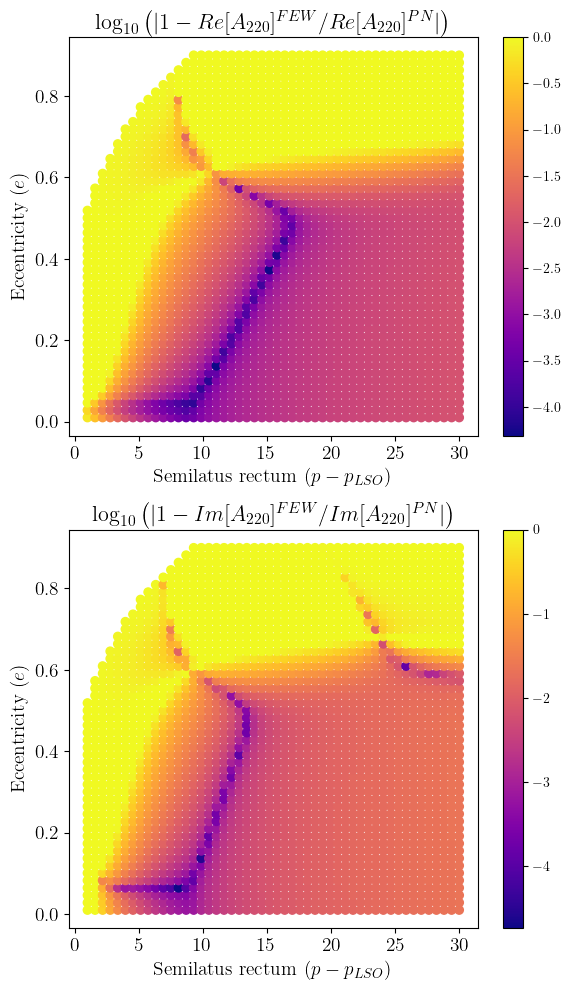

In [32]:
plot_diffs3(p3l2m2n0diffs,0)

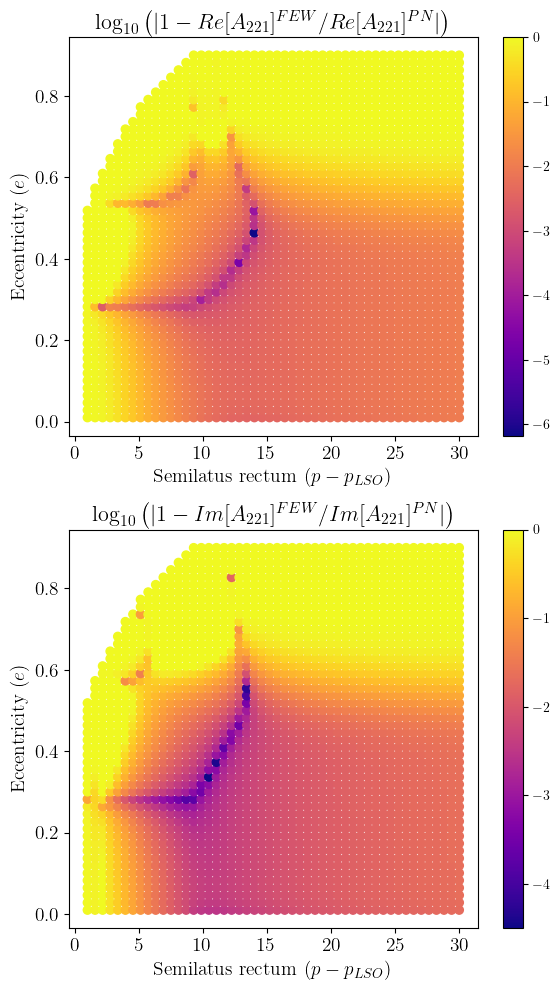

In [33]:
plot_diffs3(p3l2m2n1diffs,1)

In [23]:
PNp3l2m2n0[-40]

array([ 3.00000000e+01,  1.91632653e-01, -1.64330890e-01,  1.40471602e-02])

In [24]:
PNp3l2m2n0spherical[-40]

array([ 3.00000000e+01,  1.91632653e-01, -1.64328390e-01,  1.40469110e-02])

In [25]:
p3l2m2n0diffs[-40]

array([ 3.00000000e+01,  1.91632653e-01, -1.99444567e+00, -1.65312881e+00,
        1.62663955e-01, -1.37346973e-02,  1.64328390e-01, -1.40469110e-02])